In [317]:
from ImageLoader import ImageLoader, label_decoder
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.special import binom
from typing import List
import os
import pickle

SMALL_FONT = {'family': 'monospace', 'size': 11}
LARGE_FONT = {'family': 'monospace', 'weight': 'bold', 'size': 20 }


class ExploratoryDataAnalysis:

    img_heights: set = set()
    img_widths: set = set()


    def __init__(self, image_data: pd.DataFrame):
        self.image_data = image_data

        self.type_series = self.image_data['cancer_type'].map(label_decoder())
        self.image_series = self.image_data['img_array']
        self.cancer_types = list(self.type_series.unique())
        self.n_cancer_types = len(self.cancer_types)

        for i, type_ in enumerate(self.cancer_types):
            setattr(self, f'{type_}_df', self.image_data[self.image_data['cancer_type'] == i])

    def cancer_type_counts(self):
        mpl.rc('font', **SMALL_FONT)

        """print the value counts for each of the cancer subtypes and display the values on a chart"""

        print(f'The cancer type value counts are:\n{self.type_series.value_counts().to_string()}')

        """create bar chart with cancer type as x, counts as y"""
        cancer_types = self.type_series.value_counts().index
        cancer_counts = self.type_series.value_counts().values
        fig, ax = plt.subplots(figsize=(15, 10))
        bar_chart = ax.bar(x=cancer_types, height=cancer_counts)

        """calculate cancer type percentages and print them atop each bar"""
        type_percents = [round(i/len(self.type_series), 2) for i in cancer_counts]
        for i, bar in enumerate(bar_chart):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    type_percents[i],
                    ha='center', va='bottom')

        plt.title('Count by cancer type with percentages as text')
        plt.show()

    def null_check(self):
        """check for any null data within the image arrays"""

        arrays_w_nulls: int = 0
        labels_missing: int = self.type_series.isnull().sum()

        for image in self.image_series:
            array_sum = np.sum(image)
            has_nans = np.isnan(array_sum)
            arrays_w_nulls += 1 if has_nans else 0

        print(f'There are {arrays_w_nulls} images with nulls in their image array and {labels_missing} images missing labels.')


    def get_image_dims(self):
        """get the image-wise dimensions"""

        for img in self.image_series:
            height, width = img.shape[0], img.shape[1]
            self.img_heights.add(height)
            self.img_widths.add(width)

        print('Image heights are: ', self.img_heights)
        print('Image widths are: ', self.img_widths)


    def get_intensity_range(self):
        """get the pixel-wise intensity mins and maxs"""

        maxs = [np.amax(img) for img in self.image_series]
        mins = [np.amin(img) for img in self.image_series]

        print(f'The highest intesity in the range: {max(maxs)}')
        print(f'The lowest intesity in the range: {min(mins)}')


    def get_random_image(self, figsize=(30, 10)):
        mpl.rc('font', **LARGE_FONT)

        """get a random image of each of the cancer types"""
        rand_imgs = []

        for _, cancer_type in enumerate(self.cancer_types):
            index_by_type = self.type_series[self.type_series == cancer_type].index
            rand_idx = random.choice(index_by_type)
            rand_imgs.append(self.image_data.at[rand_idx, 'img_array'])

        fig, axs = plt.subplots(1, len(rand_imgs), figsize=figsize)
        for i, img in enumerate(rand_imgs):
            axs[i].set_title(f'Cancer type: {self.cancer_types[i]}')
            axs[i].imshow(img)

        plt.tight_layout()
        plt.show()


    def get_color_avgs(self):
        mpl.rc('font', **LARGE_FONT)

        """get type image arrays, for each array append the means of each color, take the mean of the means for overall color mean by type"""
        colors = ['r', 'g', 'b']

        for type_ in self.cancer_types:
            for color in colors:
                setattr(self, f'{type_}_{color}_mean', 0)

            array_values = getattr(self, f'{type_}_df')['img_array'].values
            r_mean, g_mean, b_mean = [], [], []

            for array in array_values:
                r_mean.append(np.mean([[y[0] for y in x] for x in array]))
                g_mean.append(np.mean([[y[1] for y in x] for x in array]))
                b_mean.append(np.mean([[y[2] for y in x] for x in array]))

            setattr(self, f'{type_}_r_mean', np.mean(r_mean))
            setattr(self, f'{type_}_g_mean', np.mean(g_mean))
            setattr(self, f'{type_}_b_mean', np.mean(b_mean))


        values = [[getattr(self, f'{type_}_{color}_mean') for color in colors] for type_ in self.cancer_types]

        x = np.arange(len(colors))
        width = 0.175

        fig, ax = plt.subplots(figsize=(30,10))
        cll = ax.bar(x - width, values[0], width, label='CLL')
        fl = ax.bar(x, values[1], width, label='FL')
        mcl = ax.bar(x + width, values[2], width, label='MCL')

        ax.set_ylabel('Intensity')
        ax.set_title('RGB average intensities by cancer type')
        ax.set_xticks(x)
        ax.set_xticklabels(colors)
        ax.legend()

        for bars in [cll, fl, mcl]:
            for i, bar in enumerate(bars):
                for j, _ in enumerate(colors):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width() / 2., 1.01*height,
                            f'{height:.1f}', ha='center', va='bottom')

        fig.tight_layout()
        plt.show()


    def plot_prob_transforms(self, p_values: List[float], n_poss_transforms: int):
        """plot the probabilities that n transformations are applied to a given image based on the number of possible
            transformations and the probability p of the transformer"""

        prob_dict = {}
        num_p_values = len(p_values)

        """define probabilities of specific number of transforms"""
        for p in p_values:
            p_comp = 1-p
            prob_dict[p] = {i: p**i * p_comp**(n_poss_transforms-i) * binom(n_poss_transforms, i)
                            for i in range(n_poss_transforms+1)}

        """create subplots for however many p-values input"""
        fig, axs = plt.subplots(1, num_p_values, figsize=(30, 10))
        fig.suptitle('Probability of a given number of transforms with varying p values')
        sns.set_style('dark')

        """define dual axes dict and make dual x axes for pareto"""
        axes = {i: axs for (i, axs) in enumerate(axs)}
        for i, ax in enumerate(axs):
            axes[i+num_p_values] = ax.twinx()
            axes[i+num_p_values].set_ylim(0, 1.05)

        """first create bar plot for probability values and then pareto line plot on top"""
        for i, p in enumerate(p_values):
            keys = list(prob_dict[p].keys())
            values = [prob_dict[p][k] for k in keys]
            sns.barplot(x=keys, y=values, ax=axes[i])
            axes[i].set_title(f'p={p}')

            cumulative_values = np.cumsum(values)
            sns.lineplot(x=keys, y=cumulative_values, ax=axes[i+num_p_values], color='black',
                         marker='o', markersize=10, linewidth=3)

        plt.tight_layout()
        plt.show()

In [318]:
"""importing pickled image_loader.obj created for ease of development, ImageLoader object created if pickled object not available"""
if 'image_loader.obj' in os.listdir(os.getcwd()):
    with open('image_loader.obj', 'rb') as f:
        image_data = pickle.load(f)

    eda = ExploratoryDataAnalysis(image_data)

else:
    image_data = ImageLoader('../Images')
    eda = ExploratoryDataAnalysis(image_data)

In [319]:
eda.image_data.head(3)

,cancer_type,img_array
0,0,"[[[103, 83, 117], [94, 83, 117], [87, 82, 112]..."
1,0,"[[[113, 118, 134], [122, 118, 135], [121, 118,..."
2,0,"[[[65, 59, 91], [72, 59, 89], [81, 65, 95], [8..."


In [320]:
eda.image_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cancer_type  374 non-null    int64 
 1   img_array    374 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.0+ KB


### First, we'll investigate the number of samples in each class and determine if we need to take class imbalances into account
The classes are fairly evenly represented so we don’t need to worry about any effects of imbalanced classes.

The cancer type value counts are:
FL     139
MCL    122
CLL    113


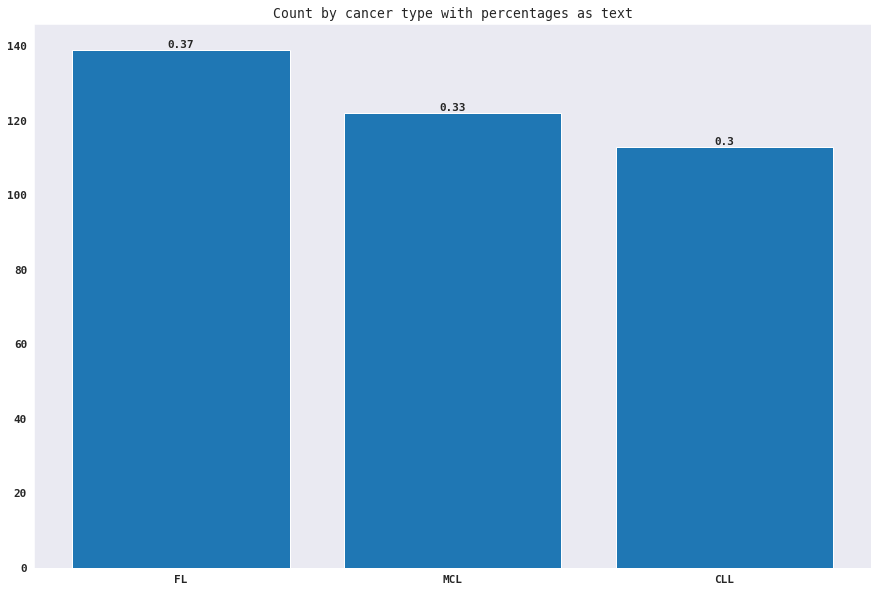

In [321]:
eda.cancer_type_counts()

#### Let's check for any nulls in the dataset that we have to deal with

In [322]:
eda.null_check()

There are 0 images with nulls in their image array and 0 images missing labels.


#### Let's check the dimensions of the images and their intensity ranges
The use of Python sets will guarantee that any uncommon image dimensions will be accounted for.  For the intensity ranges, the expectation is that the values will scale from 0 to 255 (0x00-0xFF in hex).

In [323]:
eda.get_image_dims()

Image heights are:  {1040}
Image widths are:  {1388}


In [324]:
eda.get_intensity_range()

The highest intesity in the range: 255
The lowest intesity in the range: 2


#### Next, we'll take a look at some sample images of the cancer types, just so we can get an understanding of what our data looks like visually

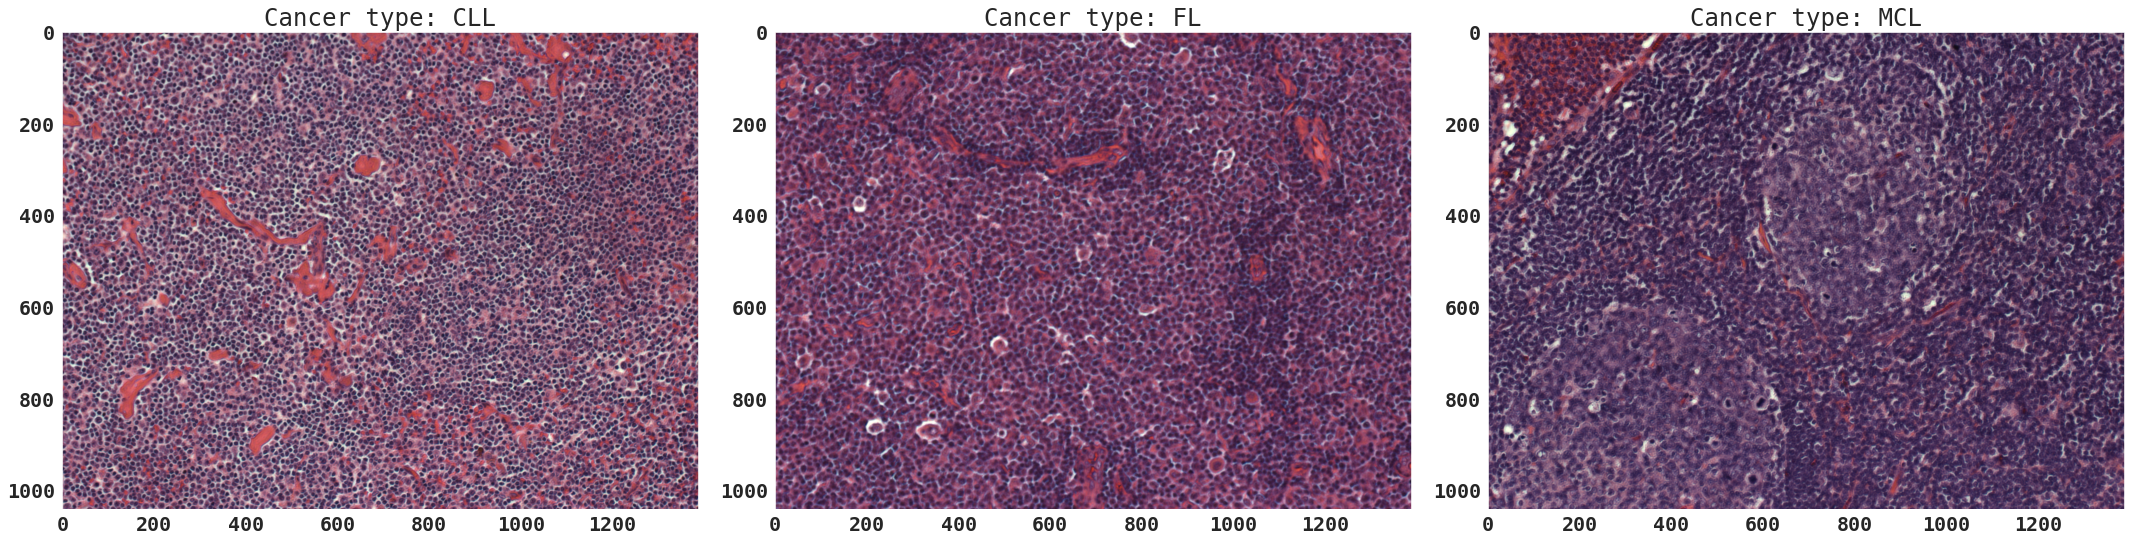

In [325]:
eda.get_random_image()

#### Given the color differences between the subtypes, let's see if there is a pattern from one type to the next about the average intensities of the samples by RGB color
Looking at the bar charts for CLL and MCL, the average values across each of the colors are quite similar.  Given that the intensities for FL are lower across the board and especially for red and green, the model's classification ability may be influenced by this factor.  This would suggest that the model could perform less well on CLL/MCL samples with lower color intesities and vice versa for FL.

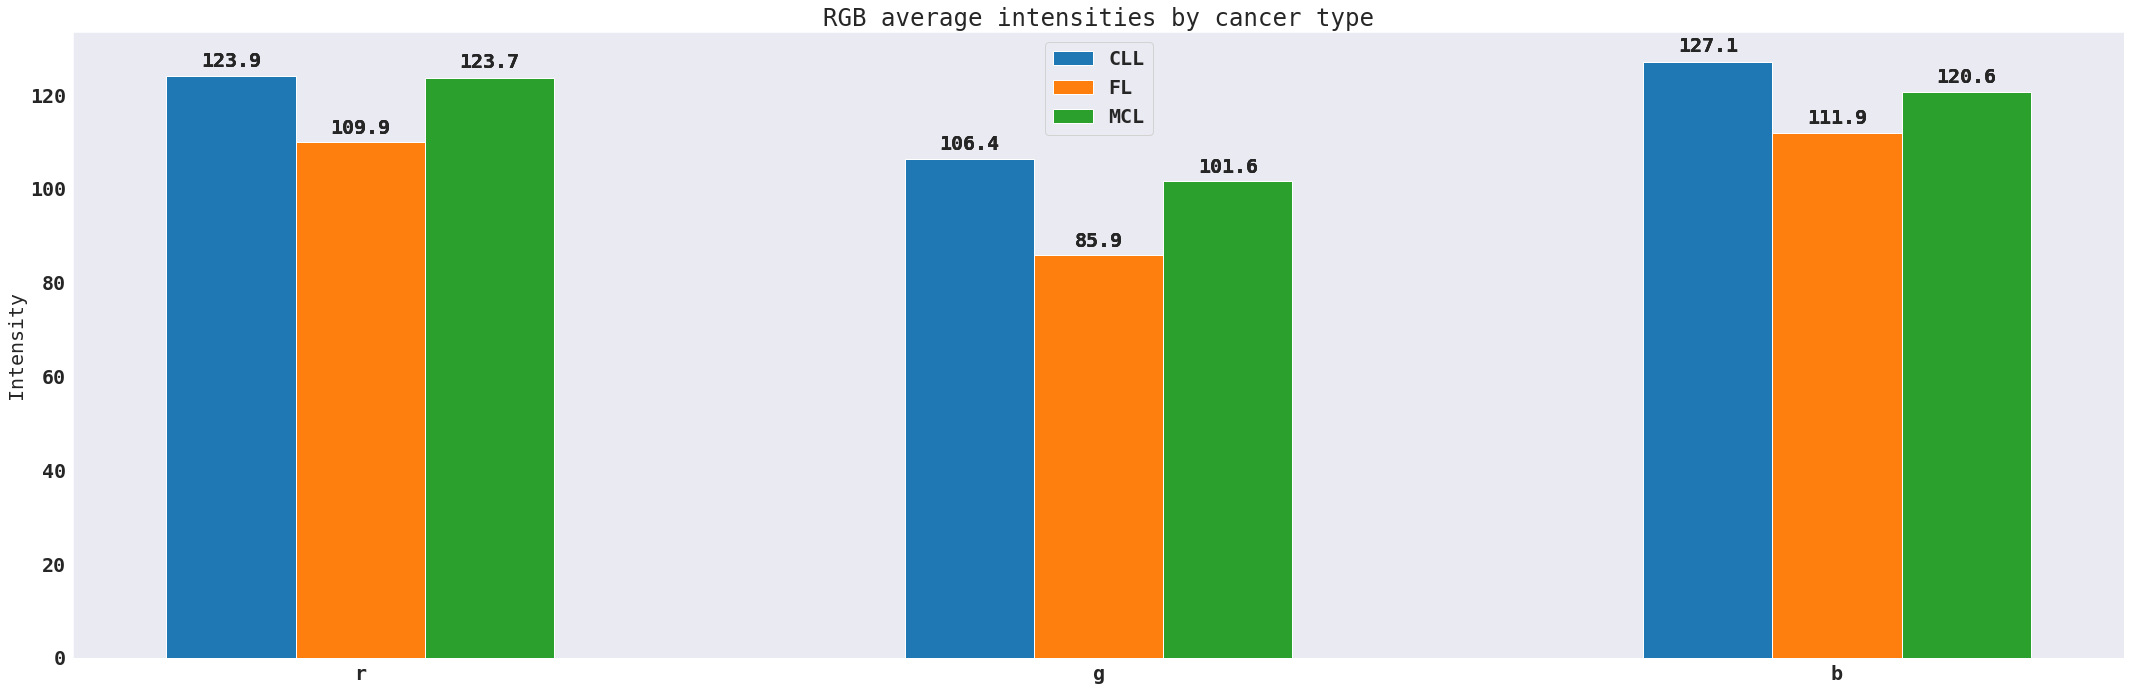

In [328]:
eda.get_color_avgs()

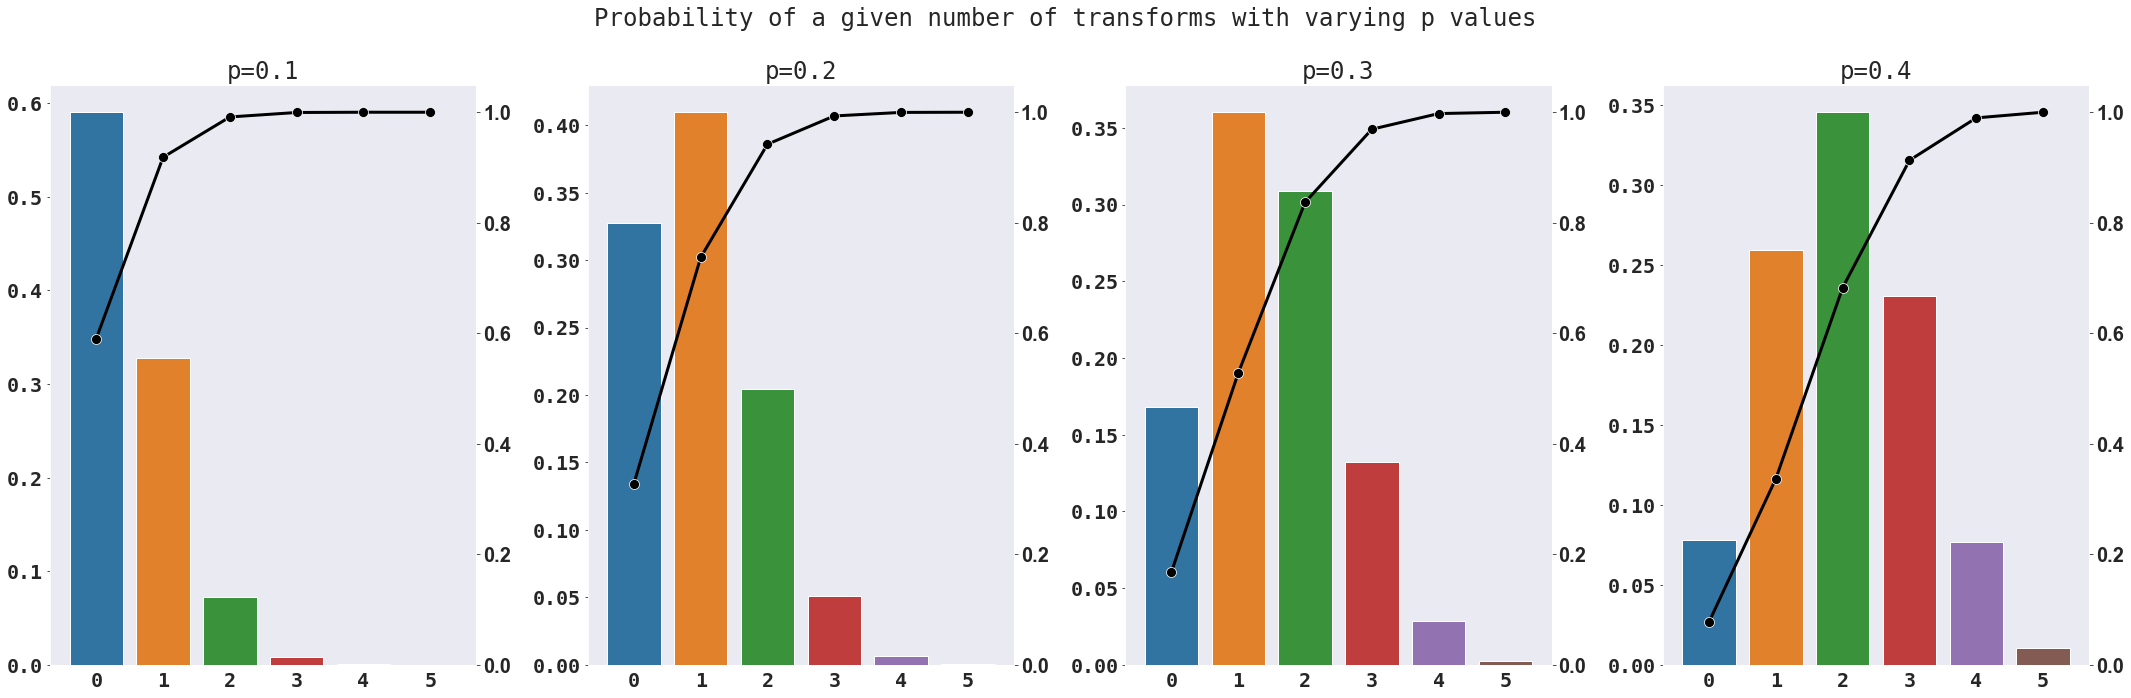

In [329]:
eda.plot_prob_transforms(p_values=[0.1, 0.2, 0.3, 0.4], n_poss_transforms=5)